In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [4]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [5]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [6]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [7]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
scan_long = np.reshape(scan, (x*y*z, b))

In [9]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [10]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [11]:
scan_long_no_background.shape

(936256, 288)

In [12]:
scan_long_no_bg_cp = scan_long_no_background

In [13]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)

(935442, 288)
(936256, 288)


In [ ]:
# Ignore data that leads to S0 in [0, 1)

# bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')
# S0 = process_data.get_S0(scan_long_no_background, bval_list)
# error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
# scan_long_no_bg = np.delete(scan_long_no_background, error_voxels, 0)
# S0_ = np.delete(S0, error_voxels, 0)
# np.save('S0_2.npy',S0_)

In [4]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [4]:
# S0 = process_data.get_S0(scan_long_no_bg, bval_list)
S0 = np.load('S0_1.npy')

In [24]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0)

In [3]:
# np.save('normalized_scan_long_2.npy', normalized_scan_long_no_background)
normalized_scan_long_no_background = np.load('normalized_scan_long_1.npy')

In [ ]:
# normalized_scan_long_no_background.shape
np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]

In [5]:
print(normalized_scan_long_no_background.shape)
print(S0.shape)

(935439, 288)


In [6]:
np.argwhere(normalized_scan_long_no_background>10)

array([[117489,      4],
       [117489,     20],
       [117489,     60],
       ...,
       [784703,    214],
       [784703,    231],
       [838711,     90]])

In [7]:
np.unique(bval_list)

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [8]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [9]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [10]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

Create batch queues.

In [11]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [14]:
net2 = Net(b_values)

Train, this might take a few minutes.

In [ ]:
# epoch, lr, layer, data size increase

In [ ]:
loss_arr=[]

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10000

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print('X_batch: ')
            print(X_batch)
            print('X_pred: ')
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.65it/s]


Loss: 1219.802162207663
Average Loss: 0.16691326795397687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.51it/s]


Loss: 1219.399515286088
Average Loss: 0.16685817122141325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.72it/s]


Loss: 1208.4785216674209
Average Loss: 0.16536378238470456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.57it/s]


Loss: 1162.1853931099176
Average Loss: 0.15902919993293893
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.13it/s]


Loss: 999.393020959571
Average Loss: 0.13675328694028066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.70it/s]


Loss: 768.3552053123713
Average Loss: 0.1051389169830831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.26it/s]


Loss: 667.0609799418598
Average Loss: 0.09127818554212641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.11it/s]


Loss: 664.4640184268355
Average Loss: 0.09092282682359545
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.80it/s]


Loss: 611.7075205817819
Average Loss: 0.08370382055032592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.71it/s]


Loss: 625.4387844353914
Average Loss: 0.08558275649088552
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  0%|▍                                                                                                       | 29/7308 [00:02<07:03, 17.17it/s]

X_batch: 
tensor([[1.0435, 0.4259, 0.3041,  ..., 0.5734, 0.1612, 0.2351],
        [1.2275, 0.4674, 0.2573,  ..., 0.4256, 0.2733, 0.2809],
        [0.9974, 0.5793, 0.1798,  ..., 0.7020, 0.4414, 0.2198],
        ...,
        [1.0603, 0.4638, 0.1896,  ..., 0.4245, 0.2576, 0.0896],
        [1.0480, 0.4328, 0.1799,  ..., 0.4550, 0.2699, 0.2394],
        [1.3836, 1.3631, 0.6751,  ..., 1.4360, 0.7046, 0.5088]])
X_pred: 
tensor([[8.9878e-01, 3.7790e-01, 2.8539e-01,  ..., 3.7737e-01, 2.8539e-01,
         2.1492e-01],
        [8.9473e-01, 2.3534e-01, 1.1631e-01,  ..., 2.3451e-01, 1.1631e-01,
         5.7074e-02],
        [8.7990e-01, 2.1884e-01, 9.0598e-02,  ..., 2.1787e-01, 9.0598e-02,
         3.7176e-02],
        ...,
        [8.9422e-01, 2.5384e-01, 1.4737e-01,  ..., 2.5315e-01, 1.4737e-01,
         8.5087e-02],
        [8.9408e-01, 3.0555e-01, 1.7298e-01,  ..., 3.0467e-01, 1.7298e-01,
         9.7373e-02],
        [1.0120e+00, 8.5043e-02, 6.8166e-03,  ..., 8.3971e-02, 6.8166e-03,
         5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.77it/s]


Loss: 654.4047054117545
Average Loss: 0.08954634721014704
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.82it/s]


Loss: 630.8701820205897
Average Loss: 0.08632596907780374
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.78it/s]


Loss: 620.0547897126526
Average Loss: 0.08484603033834874
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.70it/s]


Loss: 651.9530557068065
Average Loss: 0.08921087242840811
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.38it/s]


Loss: 661.2121592517942
Average Loss: 0.09047785430374852
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.72it/s]


Loss: 625.3676509149373
Average Loss: 0.08557302284002972
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.22it/s]


Loss: 624.618522210978
Average Loss: 0.08547051480719457
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.35it/s]


Loss: 609.5661835428327
Average Loss: 0.0834108078192163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.28it/s]


Loss: 629.426599798724
Average Loss: 0.08612843456468583
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.39it/s]


Loss: 650.4665769925341
Average Loss: 0.08900746811611031
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.64it/s]


Loss: 664.6795394504443
Average Loss: 0.09095231793246364
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.00it/s]


Loss: 596.3317596009001
Average Loss: 0.08159985763559115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.56it/s]


Loss: 621.7430770304054
Average Loss: 0.08507704940208065
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.03it/s]


Loss: 657.641268895939
Average Loss: 0.08998922672358224
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.95it/s]


Loss: 682.1794050363824
Average Loss: 0.09334693555506053
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.22it/s]


Loss: 624.3766386806965
Average Loss: 0.08543741634930166
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.83it/s]


Loss: 669.8142928238958
Average Loss: 0.0916549388100569
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.15it/s]


Loss: 596.838116729632
Average Loss: 0.08166914569370991
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.13it/s]


Loss: 696.7884005876258
Average Loss: 0.09534597709190282
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.68it/s]


Loss: 636.379063683562
Average Loss: 0.08707978430262206
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.59it/s]


Loss: 685.2418707655743
Average Loss: 0.09376599216825045
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.06it/s]


Loss: 681.2684477157891
Average Loss: 0.09322228348601383
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.25it/s]


Loss: 599.4468458769843
Average Loss: 0.08202611465202303
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.84it/s]


Loss: 663.6138926185668
Average Loss: 0.09080649871627898
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.26it/s]


Loss: 598.8864476038143
Average Loss: 0.08194943180128822
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.27it/s]


Loss: 593.5513143613935
Average Loss: 0.08121939167506752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.64it/s]


Loss: 662.5783004704863
Average Loss: 0.09066479207313714
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.70it/s]


Loss: 612.2247946113348
Average Loss: 0.08377460243723793
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.11it/s]


Loss: 599.7619149265811
Average Loss: 0.08206922754879326
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.77it/s]


Loss: 595.3178845541552
Average Loss: 0.08146112268119256
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.19it/s]


Loss: 681.997939357534
Average Loss: 0.09332210445505391
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.45it/s]


Loss: 591.0998641867191
Average Loss: 0.08088394419632171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.01it/s]


Loss: 583.2108346484601
Average Loss: 0.07980443823870555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.16it/s]


Loss: 620.5844913953915
Average Loss: 0.0849185127798839
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.69it/s]


Loss: 613.3880439018831
Average Loss: 0.08393377721700644
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.47it/s]


Loss: 596.3664492787793
Average Loss: 0.08160460444427742
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.30it/s]


Loss: 638.0159931089729
Average Loss: 0.08730377574014407
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.66it/s]


Loss: 592.4494379926473
Average Loss: 0.08106861494152262
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.77it/s]


Loss: 584.5104513047263
Average Loss: 0.07998227303020337
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.83it/s]


Loss: 622.6439019581303
Average Loss: 0.08520031499153398
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.03it/s]


Loss: 598.5192148042843
Average Loss: 0.08189918100770173
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.47it/s]


Loss: 593.3730499055237
Average Loss: 0.08119499861870877
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.47it/s]


Loss: 556.8840627986938
Average Loss: 0.0762019790364934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.08it/s]


Loss: 559.3184181111865
Average Loss: 0.07653508731680166
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.22it/s]


Loss: 637.2198251858354
Average Loss: 0.08719483103254452
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.76it/s]


Loss: 617.7998232217506
Average Loss: 0.08453746896849351
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.99it/s]


Loss: 630.0545950913802
Average Loss: 0.08621436714441437
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.56it/s]


Loss: 616.6786879198626
Average Loss: 0.08438405691295328
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.50it/s]


Loss: 610.4291653139517
Average Loss: 0.08352889508948436
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.90it/s]


Loss: 597.2806251235306
Average Loss: 0.08172969692440211
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.04it/s]


Loss: 619.2812749063596
Average Loss: 0.08474018540043235
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.85it/s]


Loss: 634.2087324885651
Average Loss: 0.08678280411720925
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.79it/s]


Loss: 583.9444000064395
Average Loss: 0.07990481664018056
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.82it/s]


Loss: 579.2542006089352
Average Loss: 0.07926302690324784
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.57it/s]


Loss: 579.2481616074219
Average Loss: 0.07926220054836096
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.27it/s]


Loss: 561.6649140268564
Average Loss: 0.0768561732384861
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.42it/s]


Loss: 594.8283695960417
Average Loss: 0.08139413924412175
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.27it/s]


Loss: 574.0135423243046
Average Loss: 0.07854591438482547
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.85it/s]


Loss: 626.584084475413
Average Loss: 0.08573947516083921
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.48it/s]


Loss: 620.5300657898188
Average Loss: 0.08491106537901187
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.84it/s]


Loss: 639.72608628124
Average Loss: 0.0875377786372797
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.36it/s]


Loss: 611.9201261452399
Average Loss: 0.0837329127182868
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.53it/s]


Loss: 584.9946714909747
Average Loss: 0.08004853195005128
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.11it/s]


Loss: 576.8470078138635
Average Loss: 0.07893363544251006
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.59it/s]


Loss: 590.1125935101882
Average Loss: 0.08074884968667052
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.62it/s]


Loss: 574.027620905079
Average Loss: 0.07854784084634359
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.01it/s]


Loss: 615.601943321526
Average Loss: 0.08423671911898277
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.41it/s]


Loss: 590.7084116814658
Average Loss: 0.08083037926675778
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 166.06it/s]


Loss: 583.6345230927691
Average Loss: 0.07986241421630666
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.84it/s]


Loss: 570.7139330240898
Average Loss: 0.07809440791243702
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.87it/s]


Loss: 557.5338142639957
Average Loss: 0.07629088865134041
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.88it/s]


Loss: 560.0709119108506
Average Loss: 0.07663805581702936
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.81it/s]


Loss: 579.8054577736184
Average Loss: 0.07933845891811965
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.46it/s]


Loss: 565.7374227978289
Average Loss: 0.07741344044852612
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.35it/s]


Loss: 559.8663101829588
Average Loss: 0.07661005886466322
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.71it/s]


Loss: 559.9898200137541
Average Loss: 0.0766269594983243
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.65it/s]


Loss: 552.9993461323902
Average Loss: 0.07567040861143817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.37it/s]


Loss: 582.3904660246335
Average Loss: 0.07969218199570792
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.97it/s]


Loss: 548.1194166899659
Average Loss: 0.07500265690886232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.18it/s]


Loss: 575.2408091863617
Average Loss: 0.07871384909501392
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.60it/s]


Loss: 559.7164848023094
Average Loss: 0.07658955730737677
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.86it/s]


Loss: 625.5328597249463
Average Loss: 0.08559562940954384
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.13it/s]


Loss: 539.6727954437956
Average Loss: 0.0738468521406398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.21it/s]


Loss: 606.0526501387358
Average Loss: 0.08293002875461628
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.55it/s]


Loss: 589.3135224855505
Average Loss: 0.08063950772927621
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.06it/s]


Loss: 532.6780586335808
Average Loss: 0.0728897179301561
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.13it/s]


Loss: 625.1269651581533
Average Loss: 0.08554008828108282
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.57it/s]


Loss: 598.0955873164348
Average Loss: 0.08184121337115967
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.14it/s]


Loss: 538.7692003315315
Average Loss: 0.07372320748926266
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.34it/s]


Loss: 557.3196987435222
Average Loss: 0.07626158986638235
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.25it/s]


Loss: 583.7571686790325
Average Loss: 0.07987919658990592
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.27it/s]


Loss: 591.3778106756508
Average Loss: 0.08092197737762052
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.57it/s]


Loss: 559.5006331144832
Average Loss: 0.07656002095162605
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.26it/s]


Loss: 529.3725307541899
Average Loss: 0.07243740158103311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.68it/s]


Loss: 563.0807215711102
Average Loss: 0.07704990716627123
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.48it/s]


Loss: 569.8534720134921
Average Loss: 0.07797666557382213
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.79it/s]


Loss: 519.4125212039798
Average Loss: 0.07107451029063763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.12it/s]


Loss: 561.5600512023084
Average Loss: 0.07684182419298144
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.81it/s]


Loss: 545.0443140803836
Average Loss: 0.0745818711111636
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.93it/s]


Loss: 539.9341746731661
Average Loss: 0.07388261831871458
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.00it/s]


Loss: 569.8931734142825
Average Loss: 0.07798209816834736
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.26it/s]


Loss: 582.138263547793
Average Loss: 0.07965767153089669
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.17it/s]


Loss: 561.4089908534661
Average Loss: 0.07682115364716285
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.52it/s]


Loss: 533.4005019539036
Average Loss: 0.07298857443266332
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.61it/s]


Loss: 559.7766406144947
Average Loss: 0.07659778880877048
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.71it/s]


Loss: 535.4757170071825
Average Loss: 0.07327253927301348
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.47it/s]


Loss: 544.2753842328675
Average Loss: 0.07447665356224241
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.01it/s]


Loss: 541.4663923769258
Average Loss: 0.07409228138709986
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.75it/s]


Loss: 544.3371144998819
Average Loss: 0.07448510050627831
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.71it/s]


Loss: 558.2191675817594
Average Loss: 0.0763846698935084
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.30it/s]


Loss: 534.1662955465727
Average Loss: 0.07309336282793824
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.61it/s]


Loss: 578.2642823420465
Average Loss: 0.07912757010701238
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 128.06it/s]


Loss: 574.9500605552457
Average Loss: 0.07867406411538666
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.89it/s]


Loss: 544.7291535027325
Average Loss: 0.07453874569002908
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.53it/s]


Loss: 547.6452539688908
Average Loss: 0.07493777421577597
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.79it/s]


Loss: 512.4087677104399
Average Loss: 0.07011614227017512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.32it/s]


Loss: 527.6081359810196
Average Loss: 0.07219596825137105
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.70it/s]


Loss: 565.8474382935092
Average Loss: 0.07742849456670897
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.40it/s]


Loss: 543.4432525024749
Average Loss: 0.07436278769875136
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.27it/s]


Loss: 511.3627130789682
Average Loss: 0.06997300397905969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.31it/s]


Loss: 594.7387014767155
Average Loss: 0.08138186938652374
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.29it/s]


Loss: 564.290219178889
Average Loss: 0.07721541039667336
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.64it/s]


Loss: 535.2393365190364
Average Loss: 0.07324019383128577
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.89it/s]


Loss: 540.954905315768
Average Loss: 0.07402229136778435
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.57it/s]


Loss: 506.25094862421975
Average Loss: 0.06927352882104813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.98it/s]


Loss: 540.5115316375159
Average Loss: 0.07396162173474492
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.06it/s]


Loss: 518.1170960511081
Average Loss: 0.07089724904913904
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.13it/s]


Loss: 513.6961671118625
Average Loss: 0.07029230529718972
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.00it/s]


Loss: 504.725783648435
Average Loss: 0.06906483082217228
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.38it/s]


Loss: 555.7489581457339
Average Loss: 0.07604665546602818
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.18it/s]


Loss: 524.8807917684317
Average Loss: 0.07182276844121945
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.99it/s]


Loss: 538.1937064351514
Average Loss: 0.0736444590086414
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.68it/s]


Loss: 562.885833370965
Average Loss: 0.07702323937752668
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.91it/s]


Loss: 545.575297774747
Average Loss: 0.07465452897848207
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.63it/s]


Loss: 543.3005510522053
Average Loss: 0.07434326095405108
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.32it/s]


Loss: 544.4801514889114
Average Loss: 0.07450467316487566
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:24<00:00, 86.78it/s]


Loss: 519.045260715764
Average Loss: 0.07102425570823262
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.60it/s]


Loss: 495.07099367585033
Average Loss: 0.06774370466281476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.32it/s]


Loss: 556.5183644383214
Average Loss: 0.07615193820995093
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.16it/s]


Loss: 486.8134527155198
Average Loss: 0.06661377294957851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.15it/s]


Loss: 512.2580204689875
Average Loss: 0.07009551456882697
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.59it/s]


Loss: 562.0088582043536
Average Loss: 0.07690323730218303
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.32it/s]


Loss: 597.2452306486666
Average Loss: 0.08172485367387337
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.04it/s]


Loss: 510.9130089636892
Average Loss: 0.06991146811216327
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.18it/s]


Loss: 514.1335210646503
Average Loss: 0.07035215121300634
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.46it/s]


Loss: 518.0586971528828
Average Loss: 0.07088925795742786
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.38it/s]


Loss: 509.2580715897493
Average Loss: 0.06968501253280641
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.52it/s]


Loss: 537.5053570424207
Average Loss: 0.07355026779452938
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.49it/s]


Loss: 532.3617867771536
Average Loss: 0.07284644044569699
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.13it/s]


Loss: 527.0625805309974
Average Loss: 0.07212131643828645
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.56it/s]


Loss: 498.0755741391331
Average Loss: 0.06815484046786167
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.11it/s]


Loss: 515.1413900996558
Average Loss: 0.07049006432671809
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 101.36it/s]


Loss: 534.3968252954073
Average Loss: 0.07312490767589044
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.29it/s]


Loss: 520.3707518624142
Average Loss: 0.07120563107039056
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.90it/s]


Loss: 497.7194339958951
Average Loss: 0.06810610755280447
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.20it/s]


Loss: 542.0147025291808
Average Loss: 0.07416731014356606
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.98it/s]


Loss: 540.9603169136681
Average Loss: 0.07402303187105475
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.08it/s]


Loss: 510.63240983430296
Average Loss: 0.06987307195324342
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.54it/s]


Loss: 569.6450801319443
Average Loss: 0.0779481499906875
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.11it/s]


Loss: 501.83030705014244
Average Loss: 0.06866862439109776
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.40it/s]


Loss: 534.7315588067286
Average Loss: 0.07317071138570451
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.52it/s]


Loss: 511.470702546183
Average Loss: 0.06998778086291503
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.61it/s]


Loss: 527.2658492135815
Average Loss: 0.07214913098160666
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.67it/s]


Loss: 521.962164612487
Average Loss: 0.07142339417248042
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.38it/s]


Loss: 502.7399916527793
Average Loss: 0.0687931023060727
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.16it/s]


Loss: 540.1671867398545
Average Loss: 0.07391450283796586
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.00it/s]


Loss: 503.00257785525173
Average Loss: 0.06882903364193374
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.65it/s]


Loss: 540.3228304148652
Average Loss: 0.07393580054937947
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.00it/s]


Loss: 507.1473819310777
Average Loss: 0.06939619347715896
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.02it/s]


Loss: 518.3304987177253
Average Loss: 0.07092645028978178
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.04it/s]


Loss: 530.2651585438289
Average Loss: 0.07255954550408167
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.77it/s]


Loss: 503.1923556760885
Average Loss: 0.06885500214505863
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.86it/s]


Loss: 499.17411054484546
Average Loss: 0.06830516017307683
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.55it/s]


Loss: 579.6637339284644
Average Loss: 0.079319065945329
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.06it/s]


Loss: 511.10726822772995
Average Loss: 0.06993804983959086
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 104.93it/s]


Loss: 509.74907268956304
Average Loss: 0.06975219932807376
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.40it/s]


Loss: 518.2816996788606
Average Loss: 0.07091977280772586
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.02it/s]


Loss: 499.4426726778038
Average Loss: 0.06834190923341596
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.32it/s]


Loss: 521.0171182821505
Average Loss: 0.07129407748797899
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.65it/s]


Loss: 497.35515552340075
Average Loss: 0.06805626101852774
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.95it/s]


Loss: 493.61295768711716
Average Loss: 0.06754419234908554
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.73it/s]


Loss: 551.4634825987741
Average Loss: 0.07546024666102547
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.99it/s]


Loss: 510.0278812320903
Average Loss: 0.0697903504696347
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.72it/s]


Loss: 516.9108879165724
Average Loss: 0.0707321959382283
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.72it/s]


Loss: 511.4951247414574
Average Loss: 0.0699911227068223
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.59it/s]


Loss: 534.2836479879916
Average Loss: 0.07310942090695013
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.23it/s]


Loss: 520.5280676092952
Average Loss: 0.07122715758200537
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.10it/s]


Loss: 494.227126785554
Average Loss: 0.06762823300294937
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.32it/s]


Loss: 497.91228626528755
Average Loss: 0.06813249675222872
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.15it/s]


Loss: 506.0437551224604
Average Loss: 0.06924517721982217
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.37it/s]


Loss: 532.6050184867345
Average Loss: 0.07287972338351593
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.47it/s]


Loss: 550.8690076209605
Average Loss: 0.07537890087862076
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.70it/s]


Loss: 530.2591275358573
Average Loss: 0.07255872024300182
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.11it/s]


Loss: 504.67641110671684
Average Loss: 0.06905807486408276
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.29it/s]


Loss: 526.9801455163397
Average Loss: 0.07211003633228512
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.08it/s]


Loss: 516.2847717935219
Average Loss: 0.07064652049719786
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.50it/s]


Loss: 509.7969377101399
Average Loss: 0.0697587490024822
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.57it/s]


Loss: 503.8734181984328
Average Loss: 0.06894819625046973
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.19it/s]


Loss: 500.50025180354714
Average Loss: 0.0684866244941909
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.33it/s]


Loss: 502.44461740367115
Average Loss: 0.0687526843737919
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.96it/s]


Loss: 478.61416808050126
Average Loss: 0.06549181281889727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.97it/s]


Loss: 504.58304502395913
Average Loss: 0.06904529899068954
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.09it/s]


Loss: 503.24883487680927
Average Loss: 0.06886273055238222
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.61it/s]


Loss: 510.7632416305132
Average Loss: 0.06989097449788084
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.16it/s]


Loss: 494.9876974718645
Average Loss: 0.06773230671481452
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.87it/s]


Loss: 484.1075079943985
Average Loss: 0.06624350136759695
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.15it/s]


Loss: 490.80968954693526
Average Loss: 0.06716060338628015
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.16it/s]


Loss: 489.0138898892328
Average Loss: 0.06691487272704336
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.35it/s]


Loss: 514.1027050162666
Average Loss: 0.07034793445761721
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.58it/s]


Loss: 518.9395611421205
Average Loss: 0.07100979216504112
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.98it/s]


Loss: 516.9300603265874
Average Loss: 0.0707348194207153
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.33it/s]


Loss: 531.8668390489183
Average Loss: 0.07277871360822637
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.95it/s]


Loss: 519.9617374152876
Average Loss: 0.07114966302891183
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.90it/s]


Loss: 501.2276731985621
Average Loss: 0.06858616217823783
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.40it/s]


Loss: 488.78305388148874
Average Loss: 0.06688328597174176
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.19it/s]


Loss: 489.87876662286
Average Loss: 0.06703321929705254
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.21it/s]


Loss: 526.1026112730615
Average Loss: 0.07198995775493452
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.89it/s]


Loss: 494.38205036567524
Average Loss: 0.06764943217921117
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.59it/s]


Loss: 524.3741621458903
Average Loss: 0.0717534430960441
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.78it/s]


Loss: 501.3198453178629
Average Loss: 0.06859877467403708
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.53it/s]


Loss: 499.93515169108286
Average Loss: 0.06840929826095825
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.80it/s]


Loss: 489.3524843174964
Average Loss: 0.06696120475061527
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.17it/s]


Loss: 491.70758998021483
Average Loss: 0.0672834687986063
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.97it/s]


Loss: 482.4878729940392
Average Loss: 0.06602187643596595
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.14it/s]


Loss: 471.9121271893382
Average Loss: 0.06457473004780216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.04it/s]


Loss: 473.6871006041765
Average Loss: 0.06481761092011173
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.27it/s]


Loss: 489.55740502430126
Average Loss: 0.06698924535088961
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.63it/s]


Loss: 489.5080436170101
Average Loss: 0.06698249091639438
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.80it/s]


Loss: 487.70787581196055
Average Loss: 0.06673616253584573
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.64it/s]


Loss: 500.8283749902621
Average Loss: 0.06853152367135497
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.63it/s]


Loss: 484.3982807532884
Average Loss: 0.06628328964878057
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.19it/s]


Loss: 491.1138958726078
Average Loss: 0.0672022298676256
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.43it/s]


Loss: 479.5676810531877
Average Loss: 0.06562228804778157
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.01it/s]


Loss: 484.88003079406917
Average Loss: 0.06634921056295419
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.91it/s]


Loss: 473.2213610536419
Average Loss: 0.06475388082288477
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.19it/s]


Loss: 508.83720513712615
Average Loss: 0.06962742270622962
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.97it/s]


Loss: 458.5945740379393
Average Loss: 0.06275240476709623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.51it/s]


Loss: 474.7025166749954
Average Loss: 0.06495655674261021
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.28it/s]


Loss: 504.49264433886856
Average Loss: 0.0690329288914708
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.96it/s]


Loss: 552.7121282108128
Average Loss: 0.07563110676119497
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.21it/s]


Loss: 616.9288895428181
Average Loss: 0.08441829358823455
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.43it/s]


Loss: 526.7821131064557
Average Loss: 0.07208293830137598
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.16it/s]


Loss: 504.68914651684463
Average Loss: 0.0690598175310406
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.87it/s]


Loss: 477.7086343327537
Average Loss: 0.06536790289172875
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.02it/s]


Loss: 499.22136978665367
Average Loss: 0.06831162695493345
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.73it/s]


Loss: 505.4348761625588
Average Loss: 0.06916186044917334
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.17it/s]


Loss: 472.05144577799365
Average Loss: 0.0645937938940878
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.93it/s]


Loss: 491.4927015732974
Average Loss: 0.06725406425469313
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.97it/s]


Loss: 490.4963224460371
Average Loss: 0.06711772337794705
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.22it/s]


Loss: 478.2842290480621
Average Loss: 0.06544666516804352
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.92it/s]


Loss: 468.2420841343701
Average Loss: 0.06407253477481802
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.51it/s]


Loss: 479.8580317874439
Average Loss: 0.06566201858065734
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.10it/s]


Loss: 489.5395193384029
Average Loss: 0.06698679793902612
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.83it/s]


Loss: 477.169567074161
Average Loss: 0.06529413889903682
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.01it/s]


Loss: 510.05317267170176
Average Loss: 0.06979381125775887
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.71it/s]


Loss: 478.42970245704055
Average Loss: 0.0654665712174385
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.11it/s]


Loss: 498.37484792945907
Average Loss: 0.06819579199910496
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.60it/s]


Loss: 496.12197246495634
Average Loss: 0.06788751675765686
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.82it/s]


Loss: 508.0164446341805
Average Loss: 0.06951511283992617
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.00it/s]


Loss: 493.0734025989659
Average Loss: 0.06747036160358044
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.67it/s]


Loss: 476.0592067325488
Average Loss: 0.06514220124966458
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.28it/s]


Loss: 473.90785180591047
Average Loss: 0.06484781770743164
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.80it/s]


Loss: 479.85590431280434
Average Loss: 0.06566172746480628
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.49it/s]


Loss: 473.64658938907087
Average Loss: 0.06481206751355649
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.81it/s]


Loss: 484.66321782488376
Average Loss: 0.06631954266897698
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.66it/s]


Loss: 464.49434684356675
Average Loss: 0.06355970810667307
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.60it/s]


Loss: 465.4727631630376
Average Loss: 0.06369359101847805
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.18it/s]


Loss: 468.5708390302025
Average Loss: 0.06411752039274801
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.47it/s]


Loss: 472.0800079978071
Average Loss: 0.06459770224381597
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.42it/s]


Loss: 476.4407898997888
Average Loss: 0.06519441569509972
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.85it/s]


Loss: 473.54936912423
Average Loss: 0.06479876424797892
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.58it/s]


Loss: 474.4847154999152
Average Loss: 0.06492675362615151
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.52it/s]


Loss: 465.23447064170614
Average Loss: 0.06366098394112016
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.89it/s]


Loss: 475.04273404739797
Average Loss: 0.06500311084392418
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.07it/s]


Loss: 457.54986855294555
Average Loss: 0.06260945108825199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.95it/s]


Loss: 467.6015026816167
Average Loss: 0.06398487995096014
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.18it/s]


Loss: 512.1314556449652
Average Loss: 0.07007819590106255
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.10it/s]


Loss: 484.328307159245
Average Loss: 0.06627371471801383
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.40it/s]


Loss: 496.4882370000705
Average Loss: 0.06793763505748092
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.33it/s]


Loss: 465.7988292556256
Average Loss: 0.06373820871040306
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.66it/s]


Loss: 464.2609876091592
Average Loss: 0.06352777608226043
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.04it/s]


Loss: 472.1179813584313
Average Loss: 0.06460289837964303
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.60it/s]


Loss: 492.3765402310528
Average Loss: 0.06737500550507017
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.21it/s]


Loss: 485.7997047249228
Average Loss: 0.06647505538107865
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.80it/s]


Loss: 446.89382626581937
Average Loss: 0.061151317223018524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.15it/s]


Loss: 463.940456175711
Average Loss: 0.06348391573285592
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.67it/s]


Loss: 485.084167976398
Average Loss: 0.066377143948604
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.06it/s]


Loss: 469.46072666486725
Average Loss: 0.06423928936300866
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.88it/s]


Loss: 493.2473820345476
Average Loss: 0.06749416831343016
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.54it/s]


Loss: 464.5577492835
Average Loss: 0.06356838386473727
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.05it/s]


Loss: 504.89387918869033
Average Loss: 0.06908783240129862
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.84it/s]


Loss: 512.3139255745336
Average Loss: 0.0701031644190659
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.63it/s]


Loss: 472.1137159066275
Average Loss: 0.06460231471081383
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.43it/s]


Loss: 480.47017491050065
Average Loss: 0.06574578200745768
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.14it/s]


Loss: 462.95793448062614
Average Loss: 0.06334947105646226
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.79it/s]


Loss: 461.0442050755955
Average Loss: 0.06308760332178373
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.57it/s]


Loss: 467.6339726508595
Average Loss: 0.06398932302283244
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.29it/s]


Loss: 454.01001111837104
Average Loss: 0.06212506993956911
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.51it/s]


Loss: 473.50136845279485
Average Loss: 0.06479219601160302
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.86it/s]


Loss: 471.4479405414313
Average Loss: 0.06451121244409296
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.11it/s]


Loss: 458.20062004961073
Average Loss: 0.06269849754373437
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.19it/s]


Loss: 461.62340738112107
Average Loss: 0.06316685924755351
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.24it/s]


Loss: 466.02602664381266
Average Loss: 0.06376929757030825
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.73it/s]


Loss: 469.26021844055504
Average Loss: 0.0642118525507054
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.84it/s]


Loss: 454.550540399272
Average Loss: 0.06219903399004816
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.80it/s]


Loss: 470.08973132492974
Average Loss: 0.06432536006088256
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.48it/s]


Loss: 454.1320890756324
Average Loss: 0.06214177464089113
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.07it/s]


Loss: 467.49963089684024
Average Loss: 0.06397094018840178
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.89it/s]


Loss: 466.66799204191193
Average Loss: 0.06385714176818719
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.81it/s]


Loss: 457.21605830686167
Average Loss: 0.06256377371467729
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.11it/s]


Loss: 490.47105851210654
Average Loss: 0.0671142663535997
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.49it/s]


Loss: 477.26400696020573
Average Loss: 0.06530706170774572
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.93it/s]


Loss: 474.89187004975975
Average Loss: 0.06498246716608645
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.30it/s]


Loss: 472.4766042996198
Average Loss: 0.06465197103169401
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.17it/s]


Loss: 470.80446370271966
Average Loss: 0.06442316142620685
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.37it/s]


Loss: 479.8048861124553
Average Loss: 0.06565474632080669
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.30it/s]


Loss: 457.6774961706251
Average Loss: 0.0626269151848146
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.94it/s]


Loss: 470.89643488358706
Average Loss: 0.06443574642632555
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.43it/s]


Loss: 491.1301894709468
Average Loss: 0.06720445942404855
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.38it/s]


Loss: 459.6216278942302
Average Loss: 0.06289294306160785
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.11it/s]


Loss: 460.34789437334985
Average Loss: 0.06299232271118635
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.03it/s]


Loss: 470.90082757594064
Average Loss: 0.06443634750628635
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.57it/s]


Loss: 467.0318305636756
Average Loss: 0.06390692810121451
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.83it/s]


Loss: 461.3967317757197
Average Loss: 0.06313584178649695
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.49it/s]


Loss: 466.1452332120389
Average Loss: 0.06378560936125327
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.97it/s]


Loss: 472.37193204881623
Average Loss: 0.06463764806360375
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.33it/s]


Loss: 471.50715673947707
Average Loss: 0.0645193153721233
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.09it/s]


Loss: 448.32379990816116
Average Loss: 0.061346989587870986
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.86it/s]


Loss: 454.975960443262
Average Loss: 0.06225724691341845
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.31it/s]


Loss: 449.53295979788527
Average Loss: 0.0615124466061693
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.40it/s]


Loss: 446.0269055967219
Average Loss: 0.06103269096835275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.16it/s]


Loss: 464.7781704561785
Average Loss: 0.06359854549208792
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.90it/s]


Loss: 453.05060866614804
Average Loss: 0.06199378881583854
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.89it/s]


Loss: 470.9045492406003
Average Loss: 0.06443685676527099
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.32it/s]


Loss: 452.13834011927247
Average Loss: 0.06186895732338157
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.13it/s]


Loss: 459.53748719068244
Average Loss: 0.06288142955537526
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.54it/s]


Loss: 456.4931308468804
Average Loss: 0.06246485096426935
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.06it/s]


Loss: 451.98434016946703
Average Loss: 0.06184788453331514
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.41it/s]


Loss: 454.51256797323003
Average Loss: 0.06219383798210592
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.11it/s]


Loss: 465.2699013366364
Average Loss: 0.06366583214787033
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.18it/s]


Loss: 467.9456856637262
Average Loss: 0.06403197669180709
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.90it/s]


Loss: 450.04477616539225
Average Loss: 0.06158248168656161
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.14it/s]


Loss: 464.98719767993316
Average Loss: 0.06362714801312715
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.22it/s]


Loss: 479.7939031547867
Average Loss: 0.06565324345303594
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.55it/s]


Loss: 465.0702485102229
Average Loss: 0.06363851238508797
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.99it/s]


Loss: 451.713255841285
Average Loss: 0.06181079034500342
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.93it/s]


Loss: 479.9372153864242
Average Loss: 0.06567285377482543
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.90it/s]


Loss: 465.1094364942983
Average Loss: 0.06364387472554711
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.05it/s]


Loss: 462.0902570737526
Average Loss: 0.06323074125256603
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.39it/s]


Loss: 451.3509943149984
Average Loss: 0.06176121980227126
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.09it/s]


Loss: 451.6689106076956
Average Loss: 0.06180472230537706
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.85it/s]


Loss: 442.51634605554864
Average Loss: 0.06055231883628197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.91it/s]


Loss: 451.18840880692005
Average Loss: 0.06173897219580187
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.12it/s]


Loss: 464.78667058749124
Average Loss: 0.063599708618978
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.55it/s]


Loss: 453.8752717692405
Average Loss: 0.06210663269967714
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.52it/s]


Loss: 449.79613208351657
Average Loss: 0.06154845813950692
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.93it/s]


Loss: 466.04774656519294
Average Loss: 0.06377226964493608
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.97it/s]


Loss: 462.3795288912952
Average Loss: 0.06327032415042354
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.96it/s]


Loss: 444.13865428743884
Average Loss: 0.0607743095631416
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.25it/s]


Loss: 453.61342476448044
Average Loss: 0.06207080251292836
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.55it/s]


Loss: 447.62015160312876
Average Loss: 0.0612507049265365
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.01it/s]


Loss: 458.4670351790264
Average Loss: 0.06273495281595873
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.99it/s]


Loss: 451.5007176762447
Average Loss: 0.061781707399595605
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.24it/s]


Loss: 449.4795752214268
Average Loss: 0.061505141655914995
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.97it/s]


Loss: 465.8370591686107
Average Loss: 0.06374343995191717
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.28it/s]


Loss: 447.743350260891
Average Loss: 0.06126756298041749
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.03it/s]


Loss: 452.60971005959436
Average Loss: 0.061933457862560805
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.59it/s]


Loss: 486.2054666755721
Average Loss: 0.06653057836283142
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.04it/s]


Loss: 459.51665996108204
Average Loss: 0.06287857963342666
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.53it/s]


Loss: 454.4147892985493
Average Loss: 0.06218045830576756
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.63it/s]


Loss: 445.4185095722787
Average Loss: 0.060949440280826314
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.72it/s]


Loss: 453.72376023977995
Average Loss: 0.062085900415952376
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.36it/s]


Loss: 450.15924039762467
Average Loss: 0.06159814455358849
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.90it/s]


Loss: 441.0243552015163
Average Loss: 0.06034816026293326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.82it/s]


Loss: 435.7342399819754
Average Loss: 0.059624280238365544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.40it/s]


Loss: 449.9949199715629
Average Loss: 0.06157565954728557
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.78it/s]


Loss: 447.3795137992129
Average Loss: 0.06121777692928474
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.68it/s]


Loss: 451.1432613185607
Average Loss: 0.06173279437856605
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.64it/s]


Loss: 460.3722248482518
Average Loss: 0.06299565200441322
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.70it/s]


Loss: 447.83275573095307
Average Loss: 0.0612797968980505
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.40it/s]


Loss: 442.0765655571595
Average Loss: 0.06049214088083737
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.49it/s]


Loss: 439.8290005675517
Average Loss: 0.06018459230535737
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.18it/s]


Loss: 458.0951912421733
Average Loss: 0.06268407105120051
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 8


 54%|██████████████████████████████████████████████████████▊                                              | 3965/7308 [00:22<00:16, 200.08it/s]

In [17]:
len(loss_arr)

448

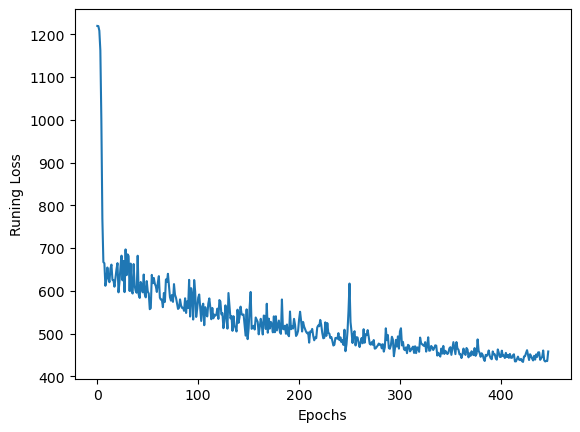

In [16]:
epoch_arr = np.arange(0, 448)
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [41]:
torch.save(final_model, 'model_1.pt')

In [ ]:
final_model

In [42]:
saved_net = Net(b_values)
saved_net.load_state_dict(torch.load('model_1.pt'))


<All keys matched successfully>

In [ ]:
saved_net.state_dict()

In [35]:
X, Dp, Dt, Fp = net(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)))

In [36]:
X[1]

tensor([0.9508, 0.7536, 0.7255, 0.6981, 0.7537, 0.6984, 0.7253, 0.7539, 0.7257,
        0.6983, 0.7536, 0.7258, 0.6984, 0.7534, 0.7255, 0.6984, 0.9508, 0.7537,
        0.7254, 0.6980, 0.6981, 0.7537, 0.7253, 0.7537, 0.7257, 0.6987, 0.7534,
        0.7254, 0.6981, 0.7537, 0.7255, 0.6985, 0.9508, 0.6981, 0.7537, 0.7254,
        0.7539, 0.7257, 0.6985, 0.7537, 0.6987, 0.7255, 0.6981, 0.7537, 0.7253,
        0.7536, 0.7257, 0.6984, 0.9508, 0.7534, 0.7253, 0.6984, 0.6983, 0.7534,
        0.7258, 0.7534, 0.6987, 0.7253, 0.7537, 0.7257, 0.6981, 0.7536, 0.6985,
        0.7254, 0.9508, 0.7539, 0.7253, 0.6984, 0.7536, 0.7253, 0.6983, 0.7537,
        0.7253, 0.6981, 0.7534, 0.7254, 0.6980, 0.7539, 0.7253, 0.7255, 0.9508,
        0.7536, 0.6980, 0.6987, 0.7534, 0.7255, 0.6983, 0.7536, 0.7253, 0.6983,
        0.7539, 0.7253, 0.6985, 0.6983, 0.7536, 0.9508, 0.6985, 0.7537, 0.7255,
        0.7255, 0.7534, 0.7254, 0.6984, 0.7534, 0.7251, 0.6984, 0.7534, 0.7254,
        0.6980, 0.7536, 0.7253, 0.6985, 

In [37]:
normalized_scan_long_no_background[0]

array([1.30231222, 0.79474696, 0.5139521 , 0.43208811, 0.76424263,
       0.67185225, 0.62095224, 0.89252192, 0.50431463, 0.26155427,
       0.38166048, 0.655396  , 0.50740975, 0.36179775, 0.41590528,
       0.57002732, 0.90807904, 0.78176067, 0.50532199, 0.54320682,
       0.60095894, 0.57121344, 0.34920728, 0.6822784 , 0.56516249,
       0.52304688, 0.75032289, 0.5815895 , 0.58644621, 0.60180785,
       0.45803777, 0.61936955, 1.04339046, 0.64839691, 0.39603862,
       0.18933549, 0.35371684, 0.56276892, 0.34228518, 0.51946218,
       0.31336673, 0.30355206, 0.52984674, 0.43238887, 0.44295371,
       0.47000164, 0.60064617, 0.64380376, 0.85126785, 0.67112883,
       0.53182613, 0.44692895, 0.37113365, 0.61863096, 0.66124599,
       0.29644392, 0.42934769, 0.63595413, 0.60450377, 0.51659329,
       0.59525075, 0.65555411, 0.44123023, 0.33400325, 1.40246789,
       0.30419233, 0.48434566, 0.7158809 , 0.51087295, 0.42206365,
       0.36245095, 0.48321149, 0.36169222, 0.43522382, 0.74840

In [74]:
print(np.unique(bval_list))

[   5.  990.  995. 1000. 1005. 1985. 1990. 1995. 2000. 2005. 2010. 2980.
 2985. 2990. 2995. 3000. 3005. 3010.]


## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [18]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

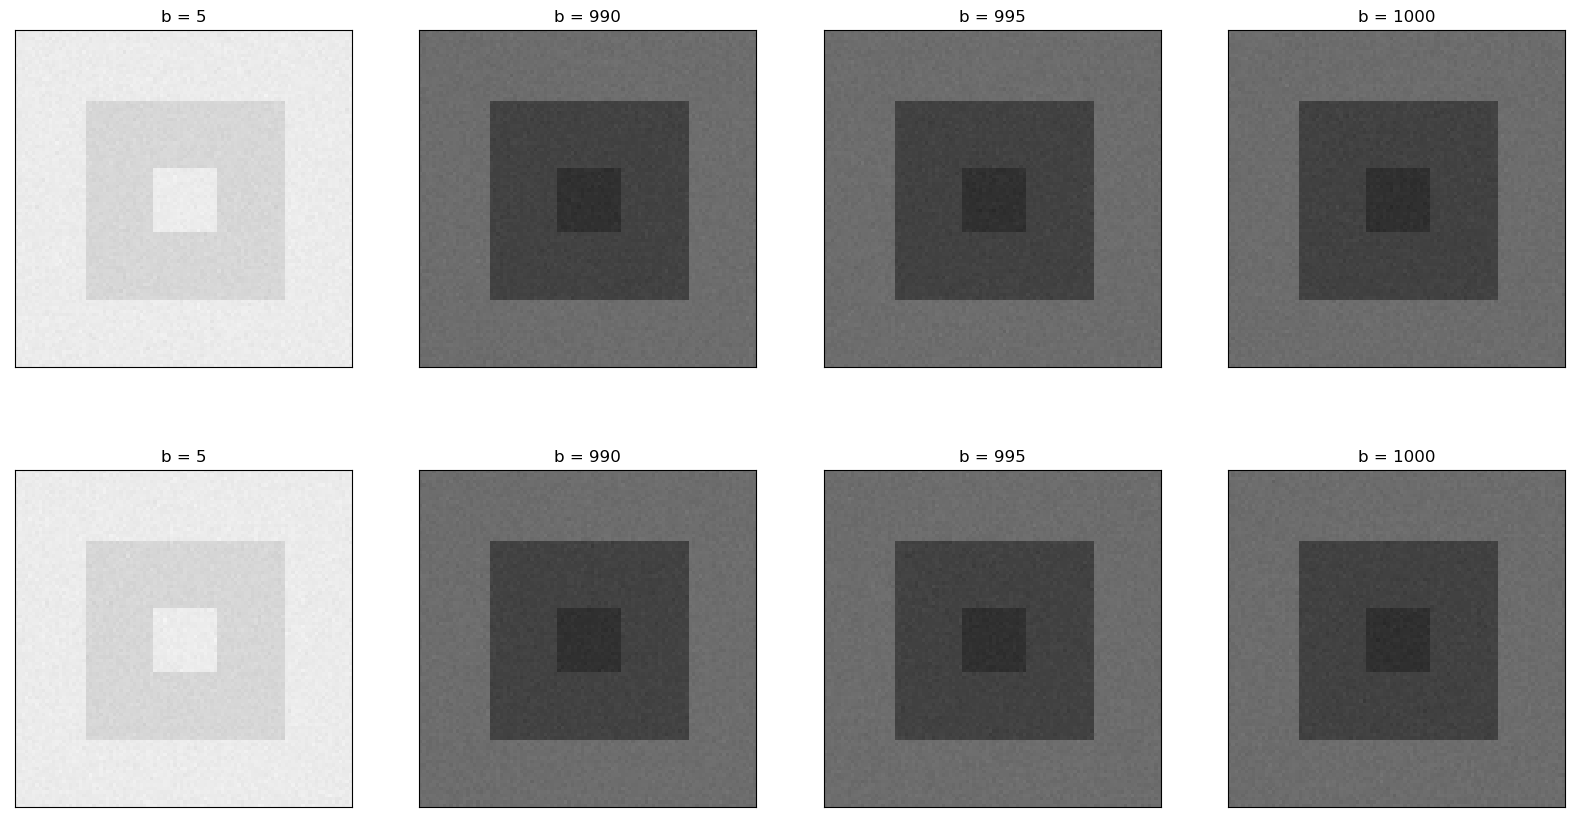

In [19]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [21]:
# net.load_state_dict(final_model)
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

In [22]:
Fp

array([[-0.28316522],
       [-0.2769339 ],
       [-0.27240443],
       ...,
       [-0.28040183],
       [-0.26601946],
       [-0.28067768]], dtype=float32)

Plot parameter estimates and corresponding ground truths.

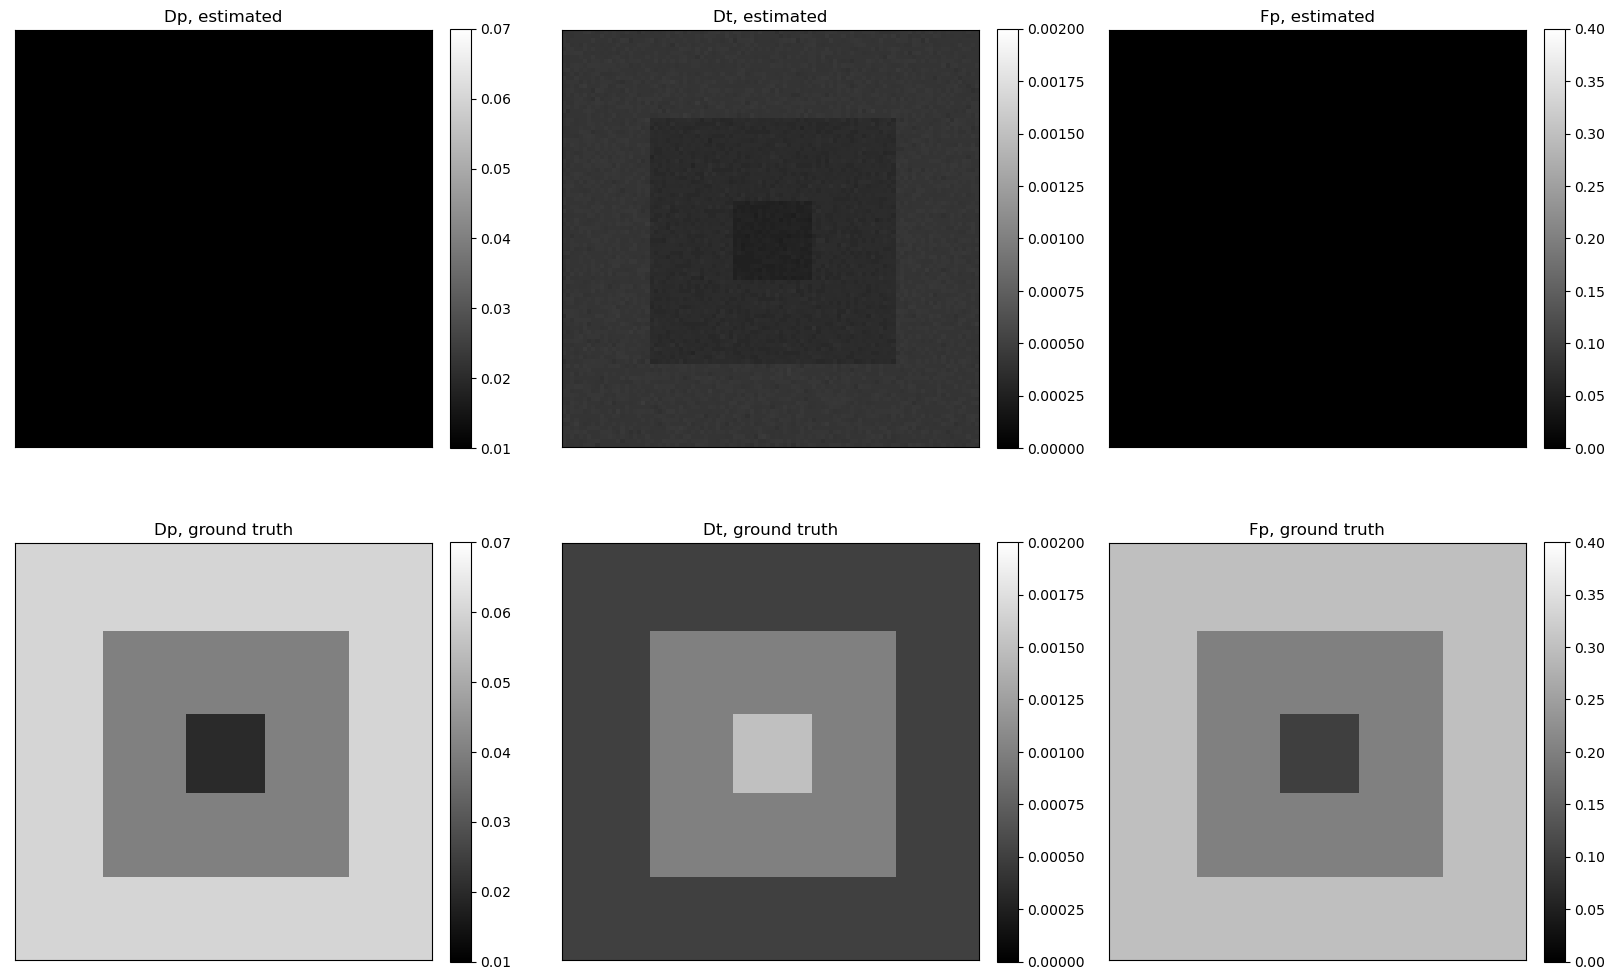

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()